# IMPORTS

In [ ]:
COLAB = False

In [ ]:
from pathlib import Path

if COLAB:
    !git clone https://github.com/abodinier/DCGAN-dose-prediction.git
    !pip install transformers
    !pip install torchmetrics
    import sys
    sys.path.append("./DCGAN-dose-prediction/")
    
    from google.colab import drive

    drive.mount('/content/gdrive')
    STORAGE = Path("/content/gdrive/MyDrive/dose-prediction")
else:
    STORAGE = Path("./")

In [251]:
import os
import sys
import time
import json
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import torch
from torch import nn
from torchsummary import summary
from torchmetrics import Accuracy
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup

from utils import log_images
from metrics import mean_absolute_error, peak_signal_to_noise_ratio, structural_similarity_index

# CONSTANTS

In [252]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_DIR = Path("./MVA-Dose-Prediction/")
Tensor = torch.cuda.FloatTensor if DEVICE == "cuda" else torch.FloatTensor

# DATA

In [253]:
if not DATA_DIR.is_dir():
    !git clone https://github.com/soniamartinot/MVA-Dose-Prediction.git

## Visualize data images

In [254]:
def plot_sample(sample_folder_path):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(np.swapaxes(np.load(sample_folder_path/'ct.npy'), 0, 1),
              cmap='gray', origin='lower')
    plt.title("CT")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(np.swapaxes(np.load(sample_folder_path/'possible_dose_mask.npy'), 0, 1),
              cmap='gray', origin='lower')
    plt.title("Possible dose mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(np.swapaxes(np.load(sample_folder_path/'structure_masks.npy').sum(axis=0), 0, 1),
              cmap='gray', origin='lower')
    plt.title("Structure masks")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(np.swapaxes(np.load(sample_folder_path/'dose.npy'), 0, 1),
              cmap='gray', origin='lower')
    plt.title("Dose")
    plt.axis('off')
    plt.show()

<Figure size 1080x720 with 0 Axes>

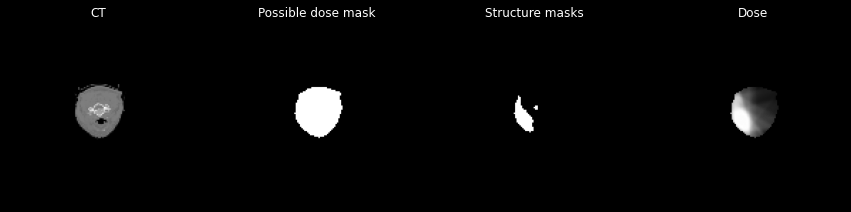

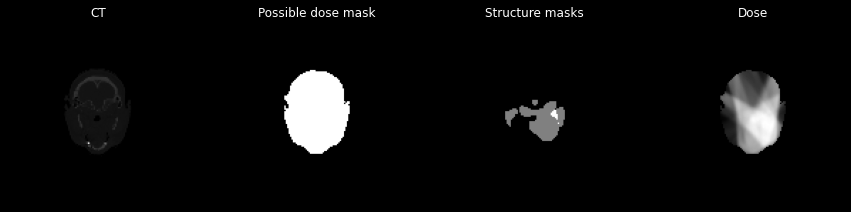

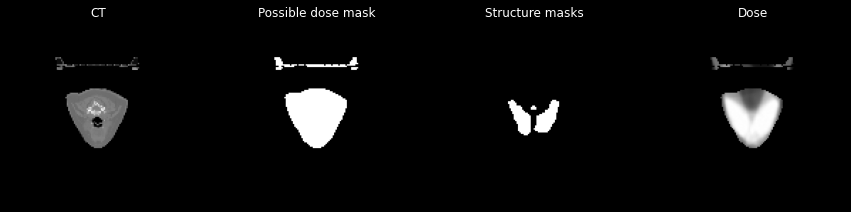

In [255]:
all_train_samples = list((DATA_DIR/"train").iterdir())
n_train_samples = len(all_train_samples)

plt.figure(figsize=(15, 10))

for i in np.random.choice(np.arange(0, n_train_samples), 3):
  path = all_train_samples[i]
  plot_sample(path)

## Dataset

In [256]:
class DoseDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode="train"):

        self.files = sorted((root/mode).iterdir())
        self.mode = mode

    def __getitem__(self, index):
        img = np.vstack(
            (
                np.load(self.files[index]/"ct.npy")[np.newaxis, :, :],
                np.load(self.files[index]/"structure_masks.npy")
            )
        )
        return {
            "ct": np.load(self.files[index]/"ct.npy"),
            "structure_masks": np.load(self.files[index]/"structure_masks.npy"),
            "img": img, 
            "possible_dose_mask": np.load(self.files[index]/"possible_dose_mask.npy"),
            "dose": np.load(self.files[index]/"dose.npy") if self.mode != "test" else None,
        }

    def __len__(self):
        return len(self.files)

# MODEL

## Architecture:
- Generator :
  - UNet
- Discrimintor :
  - 3 layer-CNN with a 2-layer Dense classification head

## Generator

Convolutional UNet with 5 downscale layers and 5 upscale layers

In [257]:
class Down(nn.Module):
    def __init__(self, in_size, out_size):
        super(Down, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)


class Up(nn.Module):
    def __init__(self, in_size, out_size):
        super(Up, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_size, out_size, kernel_size=4,
                               stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU()
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), 1)  # add the skip connection
        x = self.model(x)
        return x


class Generator(nn.Module):
    def __init__(self, in_channels=11, out_channels=1):
        super(Generator, self).__init__()

        self.down1 = Down(in_channels, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.down4 = Down(128, 256)
        self.down5 = Down(256, 256)

        self.up1 = Up(256, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 32)

        self.head = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        u1 = self.up1(d5)
        u2 = self.up2(u1, d4)
        u3 = self.up3(u2, d3)
        u4 = self.up4(u3, d2)
        
        u4 = torch.cat((u4, d1), dim=1)
        out = self.head(u4)

        return out

In [258]:
summary(Generator().to(DEVICE), input_size=(11, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           3,200
    InstanceNorm2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
              Down-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
    InstanceNorm2d-6           [-1, 64, 32, 32]               0
              ReLU-7           [-1, 64, 32, 32]               0
              Down-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
   InstanceNorm2d-10          [-1, 128, 16, 16]               0
             ReLU-11          [-1, 128, 16, 16]               0
             Down-12          [-1, 128, 16, 16]               0
           Conv2d-13            [-1, 256, 8, 8]         295,168
   InstanceNorm2d-14            [-1, 25

## Discriminator

In [259]:
class Discriminator(nn.Module):
    def __init__(self, dropout=0.1):
        super(Discriminator, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.LazyConv2d(128, 5, stride=2),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(128),
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(128, 256, 3, stride=2),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(256, 256, 3, stride=2),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(),
            torch.nn.Dropout(dropout),
            torch.nn.LazyLinear(100),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(100, 1)
        )

    def forward(self, x, labels):
        # x: the ct inputs:  [bs, 11, 128, 128]
        # labels: the dose mask:  [bs, 1, 128, 128]
        x = torch.cat((x, labels), dim=1)  # [bs, 12, 128, 128]
        return self.model(x)

# Hyper parameters

In [264]:
ALPHA = 0.5

LR_G = 1e-3
LR_D = 1e-3

N_EPOCHS = 15
BATCH_SIZE = 128

train_dataset = DoseDataset(root=DATA_DIR, mode="train_small")
test_dataset = DoseDataset(root=DATA_DIR, mode="test")
val_dataset = DoseDataset(root=DATA_DIR, mode="validation_small")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

NUM_TRAINING_STEPS = N_EPOCHS * len(train_dataloader)

hp = {
    "alpha": ALPHA,
    "lr_g": LR_G,
    "lr_d": LR_D,
    "n_epochs": N_EPOCHS,
    "batch_size": BATCH_SIZE,
    "num_training_steps": NUM_TRAINING_STEPS
}


EXP_NAME = "CNN"
TIMESTAMP = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
EXP_DIR = Path("./trains")/f"{EXP_NAME}_{TIMESTAMP}"
EXP_DIR.mkdir(exist_ok=True, parents=True)

with open(EXP_DIR/'hp.json', 'w') as f: json.dump(hp, f)

logger = SummaryWriter(log_dir=EXP_DIR/"logger", comment=str(hp))

In [265]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [266]:
%autoreload
from utils import log_images

In [267]:
l1_criterion = torch.nn.L1Loss().to(DEVICE)
cross_entropy_loss = torch.nn.BCEWithLogitsLoss().to(DEVICE)
accuracy_fn = Accuracy(task="binary").to(DEVICE)

# Initialize the generator
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

# Optimizer
optimizerG = torch.optim.Adam(
    generator.parameters(),
    lr=LR_G,
)
lr_scheduler_g = get_linear_schedule_with_warmup(optimizer=optimizerG, num_training_steps=NUM_TRAINING_STEPS, num_warmup_steps=0.1 * NUM_TRAINING_STEPS)

optimizerD = torch.optim.Adam(
    discriminator.parameters(),
    lr=LR_D,
)
lr_scheduler_d = get_linear_schedule_with_warmup(optimizer=optimizerD, num_training_steps=NUM_TRAINING_STEPS, num_warmup_steps=0.1 * NUM_TRAINING_STEPS)

prev_time = time.time()

progress_bar = tqdm_notebook(total=NUM_TRAINING_STEPS)

lr_values_d = []
lr_values_g = []

for epoch in range(N_EPOCHS):
    train_l1_loss_g = []
    train_adversarial_loss_g = []
    val_l1_loss_g = []
    val_adversarial_loss_g = []
    
    train_loss_d = []
    val_loss_d = []
    train_acc_d = []
    val_acc_d = []

    for i, batch in enumerate(train_dataloader):

        img = batch["img"].type(Tensor)
        real_dose = batch["dose"].type(Tensor)
        
        # Train Discriminator
        optimizerD.zero_grad()
        
        discriminator_on_real_dose = discriminator(img, real_dose[:, None, :, :])
        pos_sample_labels = torch.ones(size=(len(real_dose), 1), device=DEVICE)
        pos_sample_preds = torch.nn.Sigmoid()(discriminator_on_real_dose)
        
        pos_samples_loss = cross_entropy_loss(
            input=discriminator_on_real_dose, target=pos_sample_labels
        )
        
        with torch.no_grad():
            generated_dose = generator(img)
        discriminator_on_generated_dose = discriminator(img, generated_dose)
        neg_sample_labels = torch.zeros(size=(len(real_dose), 1), device=DEVICE)
        neg_samples_loss = cross_entropy_loss(
            input=discriminator_on_generated_dose, target=neg_sample_labels
        )
        neg_sample_preds = torch.nn.Sigmoid()(discriminator_on_generated_dose)
        
        discriminator_loss = (pos_samples_loss + neg_samples_loss) / 2
        discriminator_loss.backward()
        optimizerD.step()
        lr_values_d.append(optimizerD.param_groups[0]["lr"])
        lr_scheduler_d.step()
        
        train_loss_d.append(discriminator_loss.item())
        
        d_acc = accuracy_fn(
            torch.cat((pos_sample_preds, neg_sample_preds), dim=-1),
            torch.cat((pos_sample_labels, neg_sample_labels), dim=-1).type(torch.int)
        ).item()
        train_acc_d.append(d_acc)
        
        
        # Train Generator
        optimizerG.zero_grad()
        generated_dose = generator(img)
        generator_l1_loss = l1_criterion(
            input=generated_dose,
            target=real_dose
        )
        discriminator_on_generated_dose = discriminator(img, generated_dose)
        generator_adversarial_loss = cross_entropy_loss(
            input=discriminator_on_generated_dose,
            target=torch.ones(size=(len(real_dose), 1), device=DEVICE)
        )
        
        generator_loss = ALPHA * generator_adversarial_loss + (1 - ALPHA) * generator_l1_loss
        generator_loss.backward()
        optimizerG.step()
        lr_values_g.append(optimizerG.param_groups[0]["lr"])
        lr_scheduler_g.step()
        
        train_l1_loss_g.append(generator_l1_loss.item())
        train_adversarial_loss_g.append(generator_adversarial_loss.item())
    
    logger.add_scalar(tag=f"train/discrimintor_loss", scalar_value=np.mean(train_loss_d), global_step=epoch)
    logger.add_scalar(tag=f"train/discrimintor_accuracy", scalar_value=np.mean(train_acc_d), global_step=epoch)
    logger.add_scalar(tag=f"train/generator_l1_loss", scalar_value=np.mean(train_l1_loss_g), global_step=epoch)
    logger.add_scalar(tag=f"train/generator_adversarial_loss", scalar_value=np.mean(train_adversarial_loss_g), global_step=epoch)

    for batch in DataLoader(train_dataset, batch_size=5, shuffle=True):
        break
    fig = log_images(batch, generator, discriminator, Tensor)
    logger.add_figure(tag=f"train/image", figure=fig, global_step=epoch)
    
    for i, batch in enumerate(val_dataloader):
        with torch.no_grad():
            img = batch["img"].type(Tensor)
            real_dose = batch["dose"].type(Tensor)

            generated_dose = generator(img)
            discriminator_on_real_dose = discriminator(img, real_dose[:, None, :, :])
            discriminator_on_generated_dose = discriminator(img, generated_dose)
            
            pos_sample_labels = torch.ones(size=(len(real_dose), 1), device=DEVICE)
            neg_sample_labels = torch.zeros(size=(len(real_dose), 1), device=DEVICE)
            pos_sample_preds = torch.nn.Sigmoid()(discriminator_on_real_dose)
            neg_sample_preds = torch.nn.Sigmoid()(discriminator_on_generated_dose)
            
            pos_samples_loss = cross_entropy_loss(
                input=discriminator_on_real_dose, target=pos_sample_labels
            )
            
            neg_samples_loss = cross_entropy_loss(
                input=discriminator_on_generated_dose, target=neg_sample_labels
            )
            
            discriminator_loss = (pos_samples_loss + neg_samples_loss) / 2
            
            val_loss_d.append(discriminator_loss.item())
            
            d_acc = accuracy_fn(
                torch.cat((pos_sample_preds, neg_sample_preds), dim=-1),
                torch.cat((pos_sample_labels, neg_sample_labels), dim=-1).type(torch.int)
            ).item()
            val_acc_d.append(d_acc)
            
            generator_l1_loss = l1_criterion(
                input=generated_dose,
                target=real_dose
            )
            generator_adversarial_loss = cross_entropy_loss(
                input=discriminator_on_generated_dose,
                target=torch.ones(size=(len(real_dose), 1), device=DEVICE)
            )
            
            generator_loss = ALPHA * generator_adversarial_loss + (1 - ALPHA) * generator_l1_loss
            
            val_l1_loss_g.append(generator_l1_loss.item())
            val_adversarial_loss_g.append(generator_adversarial_loss.item())

    logger.add_scalar(tag=f"val/discrimintor_loss", scalar_value=np.mean(val_loss_d), global_step=epoch)
    logger.add_scalar(tag=f"val/discrimintor_accuracy", scalar_value=np.mean(val_acc_d), global_step=epoch)
    logger.add_scalar(tag=f"val/generator_l1_loss", scalar_value=np.mean(val_l1_loss_g), global_step=epoch)
    logger.add_scalar(tag=f"val/generator_adversarial_loss", scalar_value=np.mean(val_adversarial_loss_g), global_step=epoch)
    
    progress_bar.update(1)
    progress_bar.set_description(f"EPOCH [{epoch + 1}/{N_EPOCHS}]\nDiscriminator: Val Loss: {np.mean(val_loss_d):.2f}\nGenerator: Val Loss: {ALPHA * np.mean(val_l1_loss_g) + (1 - ALPHA) * np.mean(val_adversarial_loss_g):.2f}")

/var/folders/gz/jqqnqd2d36nc0gqq8l5dpdww0000gn/T/ipykernel_80173/2246317484.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(total=NUM_TRAINING_STEPS)


  0%|          | 0/15 [00:00<?, ?it/s]

# EVALUATE

In [ ]:
def evaluate_generator(generator):
    """Evaluate a generator.

    Args:
        generator: (GeneratorUNet) neural network generating T2-w images

    """
    res_train, res_test = [], []

    cuda = True if torch.cuda.is_available() else False
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    with torch.no_grad():

        for i, batch in enumerate(train_dataloader):

            # Inputs T1-w and T2-w
            real_img = batch["img"].type(Tensor)
            real_dose = batch["dose"].type(Tensor)
            real_possible_dose_mask = batch["possible_dose_mask"].type(Tensor)
            fake_dose = generator(real_img)
            fake_dose = (real_possible_dose_mask*fake_dose[:, 0, :,:])

            mae = mean_absolute_error(real_dose, fake_dose).item()
            psnr = peak_signal_to_noise_ratio(real_dose, fake_dose).item()
            ssim = structural_similarity_index(real_dose, fake_dose).item()

            res_train.append([mae, psnr, ssim])

        for i, batch in enumerate(val_dataloader):

            # Inputs T1-w and T2-w
            real_img = batch["img"].type(Tensor)
            real_dose = batch["dose"].type(Tensor)
            real_possible_dose_mask = batch["possible_dose_mask"].type(Tensor)
            fake_dose = generator(real_img)
            fake_dose = (real_possible_dose_mask*fake_dose[:, 0, :,:])

            mae = mean_absolute_error(real_dose, fake_dose).item()
            psnr = peak_signal_to_noise_ratio(real_dose, fake_dose).item()
            ssim = structural_similarity_index(real_dose, fake_dose).item()

            res_test.append([mae, psnr, ssim])

        df = pd.DataFrame([
            pd.DataFrame(res_train, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze(),
            pd.DataFrame(res_test, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze()
        ], index=['Training set', 'Test set']).T
    return df

In [ ]:
df = evaluate_generator(generator)

In [ ]:
df

,Training set,Test set
MAE,2.890694,2.868186
PSNR,-21.373302,-21.123186
SSIM,0.001299,0.001497
